In [1]:
#Import packages 
import xarray as xr
import pyrams.xarray
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from glob import glob
from tqdm import tqdm
import pint_xarray

ureg = pint_xarray.unit_registry

import numpy as np
import matplotlib.pyplot as plt
from metpy.calc import mixing_ratio_from_relative_humidity, relative_humidity_from_mixing_ratio
from metpy.units import units
from metpy.constants import g, Rd, Lv, Cp_d, Rv, rho_d
from metpy.calc import temperature_from_potential_temperature, mixing_ratio_from_relative_humidity
from scipy.optimize import curve_fit

In [2]:
#open the simulation datasets
simlist = [
    '20',
    '200',
    '400',
    '600',
    '800',
    '1000',
]

sims = {}
for sim in simlist:
    data = xr.open_dataset(f'model_data/{sim}.nc')
    data = data.rams.apply_variable_metadata()
    data['time'] = (data.time - data.time[0]) / np.timedelta64(1,'h')
    data.time.attrs['units'] = 'hour'    
    sims[sim] = data
    
for name, ds in tqdm(sims.items()):
    ds = ds.pint.dequantify()

cmap = plt.get_cmap('jet', len(sims))

#open the sensitivity simulation datasets
simlist2 = [
    '400',
    '400-subs',
    '400-inv',
    '400-cool',
    '400-stable',
    '1000',
    '1000-subs',
    '1000-inv',
    '1000-cool',
    '1000-stable',
]

sims2 = {}
for sim in simlist2:
    data = xr.open_dataset(f'model_data/{sim}.nc')
    data = data.rams.apply_variable_metadata()
    data['time'] = (data.time - data.time[0]) / np.timedelta64(1,'h')
    data.time.attrs['units'] = 'hour'    
    sims2[sim] = data
    
for name, ds in tqdm(sims2.items()):
    ds = ds.pint.dequantify()

cmap2 = plt.get_cmap('jet', len(sims2)/2)

plots_dir = './plots/'

abc='abcdefghij'

100%|██████████| 6/6 [00:00<00:00, 131.86it/s]


100%|██████████| 10/10 [00:00<00:00, 144.07it/s]


In [4]:
for name, ds in sims.items():
    print(ds.VFLXW.time)

<xarray.DataArray 'time' (time: 121)>
array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,  2.25,
        2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,  4.  ,  4.25,  4.5 ,  4.75,
        5.  ,  5.25,  5.5 ,  5.75,  6.  ,  6.25,  6.5 ,  6.75,  7.  ,  7.25,
        7.5 ,  7.75,  8.  ,  8.25,  8.5 ,  8.75,  9.  ,  9.25,  9.5 ,  9.75,
       10.  , 10.25, 10.5 , 10.75, 11.  , 11.25, 11.5 , 11.75, 12.  , 12.25,
       12.5 , 12.75, 13.  , 13.25, 13.5 , 13.75, 14.  , 14.25, 14.5 , 14.75,
       15.  , 15.25, 15.5 , 15.75, 16.  , 16.25, 16.5 , 16.75, 17.  , 17.25,
       17.5 , 17.75, 18.  , 18.25, 18.5 , 18.75, 19.  , 19.25, 19.5 , 19.75,
       20.  , 20.25, 20.5 , 20.75, 21.  , 21.25, 21.5 , 21.75, 22.  , 22.25,
       22.5 , 22.75, 23.  , 23.25, 23.5 , 23.75, 24.  , 24.25, 24.5 , 24.75,
       25.  , 25.25, 25.5 , 25.75, 26.  , 26.25, 26.5 , 26.75, 27.  , 27.25,
       27.5 , 27.75, 28.  , 28.25, 28.5 , 28.75, 29.  , 29.25, 29.5 , 29.75,
       30.  ])
Coordinates:
  * time  

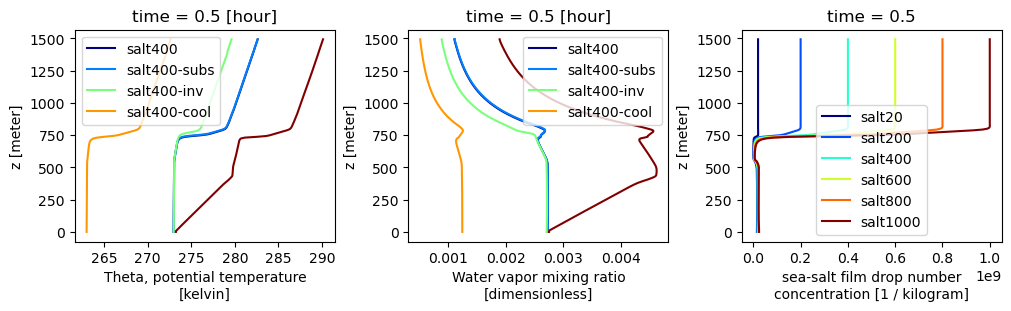

In [29]:
#Initial* conditions - Need to make this pretty
#Actually, conditions at 0.5 hrs after some model spin up
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,3), constrained_layout=True)
#first two loop over sensitivity tests
for i,(name, ds) in enumerate(sims2.items()):
    ds = ds.isel(time=2)
    ds.THETA.plot(y='z', ax=ax1, color=cmap2(i), label='salt'+name)
    if i==4: #because I don't know how to loop over just some of the simulations
        break
    ax1.legend(loc='upper left')
    
for i,(name, ds) in enumerate(sims2.items()):
    ds = ds.isel(time=2)
    ds.RV.plot(y='z', ax=ax2, color=cmap2(i), label='salt'+name)
    if i==4:
        break

    ax2.legend()
#loops over salt profiles
for i,(name, ds) in enumerate(sims.items()):
    ds = ds.isel(time=2)
    ds.SALT_FILM_NP.plot(y='z', ax=ax3, color=cmap(i), label='salt'+name)
    ax3.legend()

#and finally, save it

In [7]:
#Define functions to calculate cloud normalized height and BL normalized height and execute them.
def cloudboundary(ds):
    ctoparr = []
    cbotarr = []
    zl, tl = len(ds.z), len(ds.time)
    for t in range(tl):
        dst = ds.isel(time=t)
        top = False
        if dst.RCP.max() >= 1e-5:
            for z in reversed(range(zl)):
                if top and dst.RCP.isel(z=z) < 1e-5 : 
                    cbotarr.append(dst.z[z+1].data)
                    break
                elif not top and dst.RCP.isel(z=z) >= 1e-5:
                    ctoparr.append(dst.z[z].data)
                    top = True
        else:
            cbotarr.append(np.nan)
            ctoparr.append(np.nan)
    # ctoparr
    cloud_top = xr.DataArray(ctoparr, coords=dict(time=ds.time))
    cloud_bot = xr.DataArray(cbotarr, coords=dict(time=ds.time))
    ds['CLOUD_TOP'] = cloud_top
    ds['CLOUD_BOT'] = cloud_bot
    return ds

def logistic(x, L, k, x0, c):
    y = L / (1 + np.exp(-k * (x-x0))) + c
    return y

def bltop(ds):
    bltops = []
    # bltopsb = []
    for t in ds.time:
        ds1 = ds.sel(time=t)
        x = ds1.THETA.z
        y = ds1.THETA

        coefs = [20, 1/10, 800, 260]
        (L, k, x0, c),_ = curve_fit(logistic, x, y, p0=coefs)

        # equation for minimum of 2nd derivative of logistic eq (highest curvature)
        # smaller 0 (bottom of inversion)
        # bltops.append((k*x0 - np.log(2 - np.sqrt(3)))/k) 
        bltops.append((k*x0 - np.log(2 + np.sqrt(3)))/k) #equation for minimum of 2nd     
        
    darr = xr.DataArray(
        bltops,
        coords = [ds.time.data],
        dims = ["time"]
    )
    ds['BLTOP'] = darr
    return ds

#Execute the functions
for name,ds in tqdm(sims.items()):
    ds = cloudboundary(ds)
    ds = bltop(ds)
    sims[name] = ds
    
for name, ds in tqdm(sims.items()):
    Z_NORM_CLOUD = np.zeros((len(ds.time), len(ds.z)))
    Z_NORM_BLTOP = np.zeros((len(ds.time), len(ds.z)))
    for t in range(len(ds.time)):
        ds1 = ds.isel(time=t)
        Z_NORM_CLOUD[t,:] = (ds1.z.data - ds1.CLOUD_BOT.data)/(ds1.CLOUD_TOP - ds1.CLOUD_BOT).data
        Z_NORM_BLTOP[t,:] = ((ds1.z.data)/(ds1.BLTOP).data)

    ds = ds.assign_coords(Z_NORM_CLOUD = (['time', 'z'], Z_NORM_CLOUD))
    ds = ds.assign_coords(Z_NORM_BLTOP = (['time', 'z'], Z_NORM_BLTOP))
    
    sims[name] = ds

#Throws a warning about divide by 0, this is okay and expected when cloudtop==cloudbot

  0%|          | 0/6 [00:00<?, ?it/s]/var/folders/hz/bdn88s0s7tgbxyfb4hcjk9jw0000gn/T/ipykernel_84430/3308069195.py:66: RuntimeWarning: divide by zero encountered in divide
  Z_NORM_CLOUD[t,:] = (ds1.z.data - ds1.CLOUD_BOT.data)/(ds1.CLOUD_TOP - ds1.CLOUD_BOT).data
/var/folders/hz/bdn88s0s7tgbxyfb4hcjk9jw0000gn/T/ipykernel_84430/3308069195.py:66: RuntimeWarning: invalid value encountered in divide
  Z_NORM_CLOUD[t,:] = (ds1.z.data - ds1.CLOUD_BOT.data)/(ds1.CLOUD_TOP - ds1.CLOUD_BOT).data
100%|██████████| 6/6 [00:06<00:00,  1.14s/it]


In [ ]:
fig, axs = plt.subplots(3, 2, sharex=True, sharey=True, constrained_layout=True, figsize=(5,5))

for i,((name, ds), ax) in enumerate(zip(sims.items(), axs.flatten())):
    ds = ds.sel(time=slice(2,30))
    p = ds.RCP.where(ds.RCP >= 0.01 * ureg('g/kg')).pint.to('g/kg').plot(x='time', vmin=0, vmax=.35, ax=ax, add_colorbar=False) 
    ax.set_title(abc[i]+') salt'+name)
    p.set_rasterized(True)
    if i%2 != 0: ax.set_ylabel('')
    else: ax.set_ylabel('Height [m]')
    if i not in [4,5]: ax.set_xlabel('')
    else: ax.set_xlabel('Time [hr]')
       
plt.ylim(0,1500)
plt.colorbar(p, ax=axs.ravel().tolist(), shrink=1, label='g kg$^{-1}$')
plt.savefig(f'{plots_dir}/03.png', dpi=500)

In [ ]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,3), constrained_layout=True)
for i,(name, ds) in enumerate(sims.items()):
    ds = ds.sel(time=slice(2,30))
    (ds.rams.lwp * ureg('m')).pint.to('g/m^2').plot(ax=ax1,x='time', label=name, color=cmap(i))

ax1.set_ylabel('LWP [g m$^{-2}$]')
ax1.set_xlabel('Time [hr]')
ax1.text(0.9, 0.9, 'a)', transform=ax1.transAxes)
    
for i,name in enumerate(sims.keys()):
    ds = sims[name]
    ds = ds.sel(time=slice(2,30))
    ((ds.RRP * ds.DN0).integrate('z') * ureg('m')).pint.to('g/m^2').plot(ax=ax2, label='salt'+name, color=cmap(i))

ax2.text(0.9,0.9,'b)',transform=ax2.transAxes)
ax2.set_xlabel('Time [hr]')
ax2.set_ylabel('RWP [g m$^{-2}$]')

for i,name in enumerate(sims.keys()):
    ds = sims[name].sel(time=slice(2,30))
    bl_mass = ds.SALT_FILM_NP.isel(z=0)*ds.DN0.isel(z=0)
    bl_mass.pint.to('1/cm^3').plot(ax=ax3, color=cmap(i), label=name)
    (ds.CCP*ds.DN0).where(ds.RCP >= 0.01 *ureg('g/kg')).mean('z').pint.to('1/cm^3').plot(ax=ax3,color=cmap(i), linestyle='--')
 
ax3.text(0.9,0.9,'c)',transform=ax3.transAxes)
ax3.set_ylabel('Number Concentration [# cm$^{-3}$]')
ax3.set_xlabel('Time [hr]')

plt.legend(ncol=1,bbox_to_anchor=(1.05, .8))

plt.savefig(f'{plots_dir}/04.png', dpi=500)

In [ ]:
fig, axs = plt.subplots(2, 4, sharey=True, constrained_layout=True, figsize=(8,4))
axs = axs.flatten()

times = [4,12,20,28]

for j in range(4):
#for t,ax in zip(times, axs):
    handles = []
    for i,(name, ds) in enumerate(sims.items()):
        ds1 = ds.sel(time=times[j])
        ax=axs[j]
        p = (ds1.CCP * ds1.DN0).pint.to('1/cm^3').plot(y='Z_NORM_CLOUD', ax=axs[j], color=cmap(i), label='salt'+name)
        ax.set_ylim(-0.1,1.1)
        ax.set_xlim(0,100)
        handles = handles + p
        ax.set_xlabel('Droplet Conc. [cm$^{-3}$]')
        ax.set_title(f'Time = {times[j]}.0 hr')
    if times[j] in [4]: 
        ax.set_ylabel('Norm. Cloud Hgt.')
    else: ax.set_ylabel('')
    
fig.supylabel('(a)\n\n\n\n\n\n\n\n\n\n\n(b)\n',rotation='horizontal')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#for t,ax in zip(times, axs):
for j in range(4):
    for i,(name, ds) in enumerate(sims.items()):
        ds1 = ds.sel(time=times[j])
        ax=axs[j+4]
        v = ds1.rams.cloudradius
        l = v.where(ds1.RCP >= 0.01 * ureg('g/kg')).pint.to('micron').plot(y='Z_NORM_CLOUD', ax=axs[j+4], color=cmap(i), label=name)
        ax.set_ylim(-0.1,1.1)
        # handles.append(p[0].get_label())
        handles = handles + l
        ax.set_xlabel('Droplet Radius [$\mu$m]')
        ax.set_xlim(0,25)
        ax.set_title('')
    if times[j] in [4]: ax.set_ylabel('Norm. Cloud Hgt.')
    else: ax.set_ylabel('')

plt.savefig(f'{plots_dir}/06.png', dpi=500)


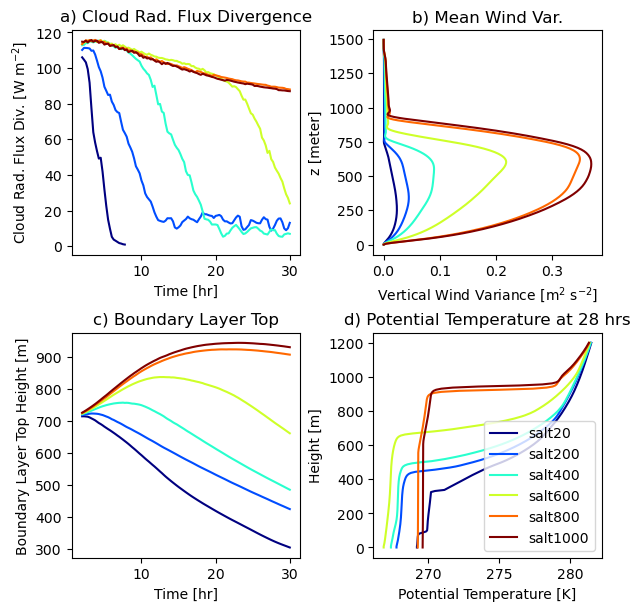

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(6,6), constrained_layout=True)
axs=axs.flatten()

cp = 1004 * ureg('J/kg/K')

for i, (name,ds) in enumerate(sims.items()):
    ds = ds.sel(time=slice(2,30))
    v = -1* (ds.FTHRD * cp * ds.DN0).where(ds.Z_NORM_CLOUD <= 1,0).where(ds.Z_NORM_CLOUD >= 0,0).integrate('z') * ureg('m')
    v[v==0]=np.nan*ureg('J/s/m^2')
    v.pint.to('W/m^2').plot(ax=axs[0], label=name, color=cmap(i))
axs[0].set_ylabel('Cloud Rad. Flux Div. [W m$^{-2}$]')
axs[0].set_xlabel('Time [hr]')
axs[0].set_title('a) Cloud Rad. Flux Divergence')

for i,name in enumerate(sims.keys()):
    ds = sims[name]
    # ds = ds.sel(time=30, z=slice(0,800))
    #uncomment later when VFLXW has proper attributes
    # ds.VFLXW.plot(y='z', label=name, color=cmap(i),ax=axs[1])
    (ds.VFLXW).sel(time=slice(2,30)).mean('time').plot(label=name, y='z', color=cmap(i),ax=axs[1])
axs[1].set_xlabel('Vertical Wind Variance [m$^2$ s$^{-2}$]')
axs[1].set_title('b) Mean Wind Var.')
# axs[1].set_ylabel('Height [m]')
# axs[1].set_xscale('log')

for i,(name, ds) in enumerate(sims.items()):
    ds = ds.sel(time=slice(2,30))
    ds.BLTOP.plot(x='time', label=name, color=cmap(i),ax=axs[2])

axs[2].set_ylabel('Boundary Layer Top Height [m]')
axs[2].set_title('c) Boundary Layer Top')
axs[2].set_xlabel('Time [hr]')

for i,(name, ds) in enumerate(sims.items()):
    ds = ds.sel(time=30, z=slice(0,1200))
    ds.THETA.plot(y='z', label='salt'+name, color=cmap(i),ax=axs[3])
    
axs[3].set_xlabel('Potential Temperature [K]')
axs[3].set_ylabel('Height [m]')
axs[3].set_title('d) Potential Temperature at 28 hrs')
axs[3].legend()

plt.savefig(f'{plots_dir}/07.png', dpi=500)

In [ ]:
fig, axs = plt.subplots(1, 5, sharex=True, sharey=True, constrained_layout=True, figsize=(7.5,2.5))
axs = axs.flatten()

times = [4, 12, 20, 28]

for t,ax in zip(times, axs):
    handles = []
    for i,(name, ds) in enumerate(sims.items()):
        ds1 = ds.sel(time=t)
        l = (ds1.FTHRD).pint.to('K/hr').plot(y='Z_NORM_CLOUD', ax=ax, color=cmap(i), label=name)
        ax.set_ylim(.8,1.1)
        # handles.append(p[0].get_label())
        handles = handles + l
        ax.set_xlabel('Heat. Rate [K hr$^{-1}$]')
        ax.set_title(f'Time = {t}.0 hr')
    if t in [4]: ax.set_ylabel('Norm. Cloud Hgt.')
    else: ax.set_ylabel('')

fax = axs[-1]
labs = [l.get_label() for l in handles]
fax.legend(handles, labs, loc='center')
fax.set_axis_off()
plt.suptitle('Radiative Heating Rate')
plt.savefig(f'{plots_dir}/08.png', dpi=500)


In [ ]:
fig, axs = plt.subplots(2,3, sharey=True, constrained_layout=True, figsize=(7,5))

times = [4, 8, 12, 16, 20, 24, 28]
colors = plt.get_cmap('viridis', len(times))

for ((name,ds), ax) in zip(sims.items(), axs.flatten()):
    for i,t in enumerate(times):
        ds1 = ds.sel(time=t)
        #aero = (ds1.THETA)
        #aero.plot(y='Z_NORM_BLTOP', ax=ax, color=colors(i), label=t)
        aero = (ds1.SALT_FILM_NP)
        ax.set_ylim(0.9, 1.4)
        aero.pint.to('1/mg').plot(y='Z_NORM_BLTOP', ax=ax, color=colors(i), label=t)
    
    ax.axhline(1, color='k', linestyle='--')
    ax.set_title('salt'+name)
    ax.set_ylabel('')   
    ax.set_xlabel('')

axs[1,0].set_xlabel('Salt Conc. [# mg$^{-3}$]')    
axs[1,1].set_xlabel('Salt Conc. [# mg$^{-3}$]') 
axs[1,2].set_xlabel('Salt Conc. [# mg$^{-3}$]') 
axs[0,0].set_ylabel('Norm. BL Height')
axs[1,0].set_ylabel('Norm. BL Height')
axs[0,0].legend(ncol=2, title='Hour', fontsize=8)
plt.savefig(f'{plots_dir}/09.png', dpi=500)

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(10,3), constrained_layout=True)
for i,(name, ds) in enumerate(sims2.items()):
    ds = ds.sel(time=slice(1,30))
    if i<5:
        (ds.rams.lwp * ureg('m')).pint.to('g/m^2').plot(ax=ax1,x='time', label=name, color=cmap2(i))
    else:
        (ds.rams.lwp * ureg('m')).pint.to('g/m^2').plot(ax=ax1,x='time', label=name, color=cmap2(i-5), linestyle='--')
        
ax1.set_ylabel('LWP [g m$^{-2}$]')
ax1.set_xlabel('Time [hr]')
ax1.text(0.9, 0.9, 'a)', transform=ax1.transAxes)
    
for i,name in enumerate(sims2.keys()):
    ds = sims2[name]
    ds = ds.sel(time=slice(1,30))
    if i<5:
        ((ds.RRP * ds.DN0).integrate('z') * ureg('m')).pint.to('g/m^2').plot(ax=ax2, label='salt'+name, color=cmap2(i))
    else: 
        ((ds.RRP * ds.DN0).integrate('z') * ureg('m')).pint.to('g/m^2').plot(ax=ax2, label='salt'+name, color=cmap2(i-5),linestyle='--')
ax2.text(0.9,0.9,'b)',transform=ax2.transAxes)
ax2.set_xlabel('Time [hr]')
ax2.set_ylabel('RWP [g m$^{-2}$]')

for i,name in enumerate(sims2.keys()):
    ds = sims2[name].sel(time=slice(1,30))
    if i<5:
        (ds.CCP*ds.DN0).where(ds.RCP >= 0.01 *ureg('g/kg')).mean('z').pint.to('1/cm^3').plot(ax=ax3,color=cmap2(i), label='salt'+name)
    else:
        (ds.CCP*ds.DN0).where(ds.RCP >= 0.01 *ureg('g/kg')).mean('z').pint.to('1/cm^3').plot(ax=ax3,color=cmap2(i-5), linestyle='--', label='salt'+name)
ax3.text(0.9,0.9,'c)',transform=ax3.transAxes)
ax3.set_xlabel('Time [hr]')
ax3.set_ylabel('Droplet Conc. [# cm$^{-3}$]')
plt.legend(ncol=1,bbox_to_anchor=(1.05, 1))

plt.savefig(f'{plots_dir}/04.png', dpi=500)